# QCNN Camera-Only Odometry (ResNet34 + QCNN + LSTM, Δt Supervision)

NameError: name 'dpkg' is not defined

In [9]:
!pip freeze > requirements.txt
!cat requirements.txt


anyio==4.5.2
appdirs==1.4.4
argon2-cffi==25.1.0
argon2-cffi-bindings==21.2.0
arrow==1.4.0
asttokens==3.0.0
async-lru==2.0.4
attrs==25.3.0
autograd==1.5
autoray==0.6.12
babel==2.17.0
backcall==0.2.0
backports.zoneinfo==0.2.1
beautifulsoup4==4.14.2
bleach==6.1.0
cachetools==5.5.2
certifi==2025.11.12
cffi==1.17.1
charset-normalizer==3.4.4
comm==0.2.3
debugpy==1.8.17
decorator==5.2.1
defusedxml==0.7.1
exceptiongroup==1.3.0
executing==2.2.1
fastjsonschema==2.21.2
fqdn==1.5.1
future==1.0.0
h11==0.16.0
httpcore==1.0.9
httpx==0.28.1
idna==3.11
importlib_metadata==8.5.0
importlib_resources==6.4.5
ipykernel==6.29.5
ipython==8.12.3
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.6
json5==0.12.1
jsonpointer==3.0.0
jsonschema==4.23.0
jsonschema-specifications==2023.12.1
jupyter-events==0.10.0
jupyter-lsp==2.3.0
jupyter_client==8.6.3
jupyter_core==5.8.1
jupyter_server==2.14.2
jupyter_server_terminals==0.5.3
jupyterlab==4.3.8
jupyterlab_pygments==0.3.0
jupyterlab_server==2.28.0
MarkupSafe==2.1.5
matplo

In [1]:
import os, sys, math
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.models as models
import pennylane as qml
from tqdm import tqdm

sys.path.append("/home/gurman_preet_526_gmail_com/lusnar_slam/src")
from lusnar_dataset import LuSNARDataset

plt.rcParams["figure.dpi"] = 120
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [2]:
DATA_ROOT = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/datasets/Moon_1")
ds = LuSNARDataset(DATA_ROOT)

gt = ds.gt.astype(np.float64)
gt_xyz = gt[:, 1:4]
color_ts = ds.color_ts.astype(np.int64)

# === Use FULL dataset (no frame cap) ===
N = min(len(color_ts), gt_xyz.shape[0])
color_ts = color_ts[:N]
t_gt = gt_xyz[:N]

print("Frames (full dataset):", N)
print("GT shape:", t_gt.shape)
print("Color timestamps shape:", color_ts.shape)

[LuSNAR] Loaded 1094 frames.
Frames (full dataset): 1094
GT shape: (1094, 3)
Color timestamps shape: (1094,)


In [3]:
# === QCNN / hybrid config & GT normalization ===
IMG_SIZE = None          # keep native camera resolution
N_QUBITS = 8
N_Q_LAYERS = 3
SEQ_LEN = 5              # number of Δt steps per training sample

# Normalize scale of translations to stabilize training
t_mean = t_gt.mean(axis=0).astype(np.float32)
t_std = t_gt.std(axis=0).astype(np.float32) + 1e-6  # avoid divide-by-zero

print("t_mean:", t_mean)
print("t_std:", t_std)

t_mean: [1.2587723e+02 1.0439057e-01 2.0924422e-01]
t_std: [7.5198135e+01 5.0854034e+00 2.9478827e-02]


In [4]:
def translation_rmse(pred, gt):
    """Compute translation RMSE (in meters)."""
    diff = pred - gt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def step_rmse(pred_dt, gt_dt):
    """RMSE over step-wise translations Δt."""
    diff = pred_dt - gt_dt
    err = np.linalg.norm(diff, axis=1)
    return float(np.sqrt(np.mean(err ** 2))), err

def trajectory_length(gt):
    """Total path length of ground-truth trajectory."""
    if gt.shape[0] < 2:
        return 0.0
    diffs = gt[1:] - gt[:-1]
    seg = np.linalg.norm(diffs, axis=1)
    return float(np.sum(seg)), seg

Img tensor shape (C,H,W): torch.Size([3, 1024, 1024])


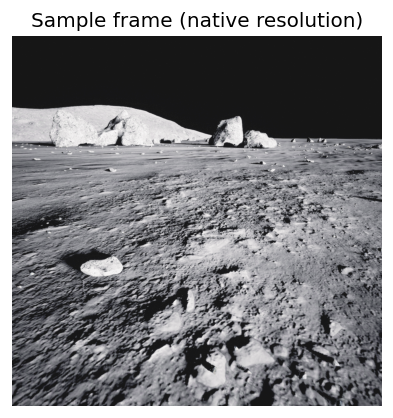

In [5]:
# Image preprocessing helper (BGR from OpenCV -> torch tensor)
def preprocess_image_bgr_to_tensor(rgb_bgr):
    """Input: BGR image (H,W,3).
    If IMG_SIZE is not None, resize to (IMG_SIZE, IMG_SIZE),
    otherwise keep native resolution.
    Output: float tensor (3, H, W) in [0,1].
    """
    rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
    if IMG_SIZE is not None:
        rgb = cv2.resize(rgb, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_AREA)
    rgb = rgb.astype(np.float32) / 255.0
    # (H,W,3) -> (3,H,W)
    rgb = np.transpose(rgb, (2, 0, 1))
    return torch.from_numpy(rgb)

# Quick sanity check and visualization
rgb0 = ds.load_rgb(int(color_ts[0]))
img_t = preprocess_image_bgr_to_tensor(rgb0)

print("Img tensor shape (C,H,W):", img_t.shape)

plt.figure(figsize=(5, 4))
plt.imshow(cv2.cvtColor(rgb0, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Sample frame (native resolution)")
plt.show()

In [6]:
# === Quantum device and QCNN block ===
qdev = qml.device("default.qubit", wires=N_QUBITS)

@qml.qnode(qdev, interface="torch")
def qcnn_block(inputs, weights):
    """QCNN-style variational block.
    inputs: (N_QUBITS,) tensor of rotation angles.
    weights: StronglyEntanglingLayers parameters.
    """
    qml.AngleEmbedding(inputs, wires=range(N_QUBITS))
    qml.StronglyEntanglingLayers(weights, wires=range(N_QUBITS))
    return [qml.expval(qml.PauliZ(i)) for i in range(N_QUBITS)]

weight_shapes = {"weights": (N_Q_LAYERS, N_QUBITS, 3)}
QuantumLayer = qml.qnn.TorchLayer(qcnn_block, weight_shapes)


class HybridQCNNLSTMResNet34(nn.Module):
    """ResNet34 + QCNN + LSTM for camera-only odometry.

    Input: sequence of frames (B, T, 3, H, W)
    Output: sequence of normalized Δt translations (B, T-1, 3)
    """
    def __init__(self):
        super().__init__()

        # === 1. CNN Backbone (ResNet34 pretrained) ===
        resnet = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])  # -> (B, 512, 1, 1)

        # === 2. Map CNN features to quantum rotation angles ===
        self.to_angles = nn.Linear(512, N_QUBITS)

        # === 3. Quantum convolution layer ===
        self.qconv = QuantumLayer

        # === 4. LSTM over quantum features ===
        self.lstm = nn.LSTM(
            input_size=N_QUBITS,
            hidden_size=64,
            num_layers=1,
            batch_first=True
        )

        # === 5. Regression head: LSTM -> Δt (x,y,z) ===
        self.head = nn.Linear(64, 3)

    def forward(self, x_seq):
        """x_seq: (B, T, 3, H, W) -> returns (B, T-1, 3) normalized Δt"""
        B, T, C, H, W = x_seq.shape

        # Merge time into batch for CNN+QCNN
        x_flat = x_seq.view(B * T, C, H, W)           # (B*T,3,H,W)
        feat = self.cnn(x_flat)                       # (B*T,512,1,1)
        feat = feat.view(B * T, -1)                   # (B*T,512)

        angles = self.to_angles(feat)                 # (B*T,N_QUBITS)
        angles = torch.tanh(angles) * math.pi

        qfeat = self.qconv(angles)                    # (B*T,N_QUBITS)
        qfeat_seq = qfeat.view(B, T, -1)              # (B,T,N_QUBITS)

        lstm_out, _ = self.lstm(qfeat_seq)            # (B,T,64)

        # We predict Δt only for transitions between frames: T-1 steps
        delta_feats = lstm_out[:, 1:, :]              # (B,T-1,64)
        dt_norm = self.head(delta_feats)              # (B,T-1,3)

        return dt_norm


class RelativePoseSequenceDataset(Dataset):
    """Returns sequences of frames and relative translations.

    For a given start index i, we take frames:
      i, i+1, ..., i+SEQ_LEN
    and targets Δt_j = t_{i+j+1} - t_{i+j} for j=0..SEQ_LEN-1.

    Input: images   -> (T=SEQ_LEN+1, 3, H, W)
    Target: Δt_norm -> (SEQ_LEN, 3)
    """
    def __init__(self, ds, color_ts, t_gt, t_std, seq_len=5):
        self.ds = ds
        self.color_ts = color_ts
        self.t_gt = t_gt.astype(np.float32)
        self.t_std = t_std.astype(np.float32)
        self.seq_len = seq_len
        # max starting index so that we have seq_len+1 frames
        self.max_start = len(color_ts) - (seq_len + 1)

    def __len__(self):
        return max(0, self.max_start + 1)

    def __getitem__(self, idx):
        start = idx
        end = start + self.seq_len + 1          # frames [start, ..., start+SEQ_LEN]
        ts_seq = self.color_ts[start:end]       # length T = SEQ_LEN+1

        imgs = []
        for ts in ts_seq:
            rgb = self.ds.load_rgb(int(ts))
            imgs.append(preprocess_image_bgr_to_tensor(rgb))
        imgs = torch.stack(imgs, dim=0)         # (T,3,H,W)

        t_seq = self.t_gt[start:end]            # (T,3)
        dt = t_seq[1:] - t_seq[:-1]             # (SEQ_LEN,3)
        dt_norm = dt / self.t_std               # scale only

        return imgs, torch.from_numpy(dt_norm)


# === Build sequence dataset + loaders ===
qcam_seq_ds = RelativePoseSequenceDataset(
    ds, color_ts, t_gt, t_std, seq_len=SEQ_LEN
)

val_ratio = 0.2
n_val = int(len(qcam_seq_ds) * val_ratio)
n_train = len(qcam_seq_ds) - n_val

qcam_train, qcam_val = random_split(qcam_seq_ds, [n_train, n_val])

# batch size 2 to be safe with ResNet34 + QCNN + high-res frames
BATCH_SIZE = 2

train_loader_cam = DataLoader(
    qcam_train, batch_size=BATCH_SIZE,
    shuffle=True, num_workers=4, pin_memory=True
)
val_loader_cam = DataLoader(
    qcam_val, batch_size=BATCH_SIZE,
    shuffle=False, num_workers=4, pin_memory=True
)

qposenet = HybridQCNNLSTMResNet34().to(device)
criterion_cam = nn.MSELoss()
optimizer_cam = torch.optim.Adam(qposenet.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler_cam = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cam, factor=0.5, patience=3, verbose=True
)

print("Train/Val sizes:", len(qcam_train), len(qcam_val))
print("Total params (M):", sum(p.numel() for p in qposenet.parameters()) / 1e6)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/gurman_preet_526_gmail_com/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|███████████████████████████████████████| 83.3M/83.3M [00:00<00:00, 186MB/s]


Train/Val sizes: 872 217
Total params (M): 21.307987


/home/gurman_preet_526_gmail_com/slam-env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
def run_epoch_qcnn_seq(loader, model, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    total_loss = 0.0
    n = 0

    for xb, yb in tqdm(loader, leave=False):
        # xb: (B, T, 3, H, W)
        # yb: (B, SEQ_LEN, 3) normalized Δt
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        if optimizer is not None:
            optimizer.zero_grad()

        pred_dt = model(xb)  # (B, SEQ_LEN, 3)
        loss = criterion_cam(pred_dt, yb)

        if optimizer is not None:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)

    return total_loss / max(n, 1)


NUM_EPOCHS_CAM = 25
train_losses_cam, val_losses_cam = [], []
best_val = float("inf")
best_state = None

for epoch in range(1, NUM_EPOCHS_CAM + 1):
    print(f"\n[ResNet34+QCNN+LSTM Δt] Epoch {epoch:02d}/{NUM_EPOCHS_CAM}")
    train_loss = run_epoch_qcnn_seq(train_loader_cam, qposenet, optimizer_cam)
    val_loss = run_epoch_qcnn_seq(val_loader_cam, qposenet, optimizer=None)

    train_losses_cam.append(train_loss)
    val_losses_cam.append(val_loss)

    scheduler_cam.step(val_loss)

    if val_loss < best_val:
        best_val = val_loss
        best_state = {k: v.cpu().clone() for k, v in qposenet.state_dict().items()}

    print(f"  train={train_loss:.6f} | val={val_loss:.6f} | best_val={best_val:.6f}")

# Restore best model
if best_state is not None:
    qposenet.load_state_dict(best_state)
    qposenet.to(device)
    print("Loaded best model (val MSE = {:.6f})".format(best_val))

plt.figure(figsize=(6, 4))
plt.plot(train_losses_cam, label="Train")
plt.plot(val_losses_cam, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δt)")
plt.title("ResNet34 + QCNN + LSTM (relative pose) training")
plt.grid(True)
plt.legend()
plt.show()


[ResNet34+QCNN+LSTM Δt] Epoch 01/25


KeyboardInterrupt: 

In [ ]:
qposenet.eval()

t_mean_t = torch.from_numpy(t_mean)
t_std_t = torch.from_numpy(t_std)

# === Predict Δt for all consecutive pairs ===
dt_pred_list = []
with torch.no_grad():
    for i in range(N - 1):
        ts_pair = [int(color_ts[i]), int(color_ts[i + 1])]
        imgs = []
        for ts in ts_pair:
            rgb = ds.load_rgb(ts)
            imgs.append(preprocess_image_bgr_to_tensor(rgb))
        imgs = torch.stack(imgs, dim=0).unsqueeze(0).to(device)  # (1,2,3,H,W)

        dt_norm = qposenet(imgs)[0, 0]     # (3,) normalized Δt between i -> i+1
        dt = dt_norm.cpu() * t_std_t       # de-normalize to meters
        dt_pred_list.append(dt.numpy())

dt_pred = np.stack(dt_pred_list, axis=0)   # (N-1,3)

# === Ground-truth Δt ===
dt_gt = t_gt[1:] - t_gt[:-1]               # (N-1,3)

# === Reconstruct trajectory via cumulative sum ===
t_cam = np.zeros_like(t_gt)
t_cam[0] = t_gt[0]                         # start at GT first pose (or zeros)
for i in range(1, N):
    t_cam[i] = t_cam[i - 1] + dt_pred[i - 1]

# === RMSE metrics ===
rmse_traj, err_traj = translation_rmse(t_cam, t_gt)
rmse_step_val, err_step = step_rmse(dt_pred, dt_gt)

# === Path length & step statistics ===
path_len, step_lengths = trajectory_length(t_gt)
mean_step = float(np.mean(step_lengths)) if len(step_lengths) > 0 else 0.0

# === Percentage metrics ===
traj_rmse_pct = (rmse_traj / path_len * 100.0) if path_len > 0 else 0.0
step_rmse_pct = (rmse_step_val / mean_step * 100.0) if mean_step > 0 else 0.0

print("=== ResNet34 + QCNN + LSTM (Δt) Metrics ===")
print(f"Trajectory RMSE       : {rmse_traj:.3f} m")
print(f"Total path length     : {path_len:.3f} m")
print(f"Trajectory RMSE (%%)  : {traj_rmse_pct:.2f} % of path length")
print("---")
print(f"Step RMSE             : {rmse_step_val:.3f} m")
print(f"Mean step length      : {mean_step:.3f} m")
print(f"Step RMSE (%%)        : {step_rmse_pct:.2f} % of mean step")

# === Plots ===
plt.figure(figsize=(6, 4))
plt.plot(err_traj)
plt.xlabel("Frame")
plt.ylabel("Error [m]")
plt.title("ResNet34+QCNN+LSTM per-frame trajectory error")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(err_step)
plt.xlabel("Step")
plt.ylabel("Δt Error [m]")
plt.title("ResNet34+QCNN+LSTM per-step Δt error")
plt.grid(True)
plt.show()

plt.figure(figsize=(6, 6))
plt.plot(t_gt[:, 0], t_gt[:, 1], label="GT")
plt.plot(t_cam[:, 0], t_cam[:, 1], label="QCNN+LSTM ResNet34")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("ResNet34+QCNN+LSTM vs GT (top-down)")
plt.legend()
plt.axis("equal")
plt.grid(True)
plt.show()

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection="3d")
ax.plot(t_gt[:, 0], t_gt[:, 1], t_gt[:, 2], label="GT")
ax.plot(t_cam[:, 0], t_cam[:, 1], t_cam[:, 2], label="QCNN+LSTM ResNet34")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(err_traj, bins=40)
plt.xlabel("Trajectory Error [m]")
plt.ylabel("Count")
plt.title("Trajectory error histogram")
plt.grid(True)
plt.show()

plt.figure(figsize=(5, 4))
plt.hist(err_step, bins=40)
plt.xlabel("Δt Error [m]")
plt.ylabel("Count")
plt.title("Step-wise Δt error histogram")
plt.grid(True)
plt.show()

In [ ]:
out_dir = Path("/home/gurman_preet_526_gmail_com/lusnar_slam/results_qcnn_resnet34_lstm")
out_dir.mkdir(parents=True, exist_ok=True)

np.save(out_dir / "t_gt.npy", t_gt)
np.save(out_dir / "t_cam_qcnn_resnet34_lstm.npy", t_cam)
np.save(out_dir / "err_traj_qcnn_resnet34_lstm.npy", err_traj)
np.save(out_dir / "err_step_qcnn_resnet34_lstm.npy", err_step)
np.savez(out_dir / "metrics_qcnn_resnet34_lstm.npz",
         rmse_traj=rmse_traj,
         rmse_step=rmse_step_val,
         traj_rmse_pct=traj_rmse_pct,
         step_rmse_pct=step_rmse_pct,
         path_len=path_len,
         mean_step=mean_step,
         N=N)

print("Saved to", out_dir)